In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.14.0
1.23.5


###  Ablation Study 실습 (1) cats_vs_dogs  데이터셋 준비하기

**1) cats_vs_dogs**

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [3]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds

# setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")


(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [5]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})


In [6]:
# 데이터의 개수도 확인해 봅시다.
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [7]:
ds_info.features["label"].num_classes

2

In [8]:
ds_info.features["label"].names

['cat', 'dog']

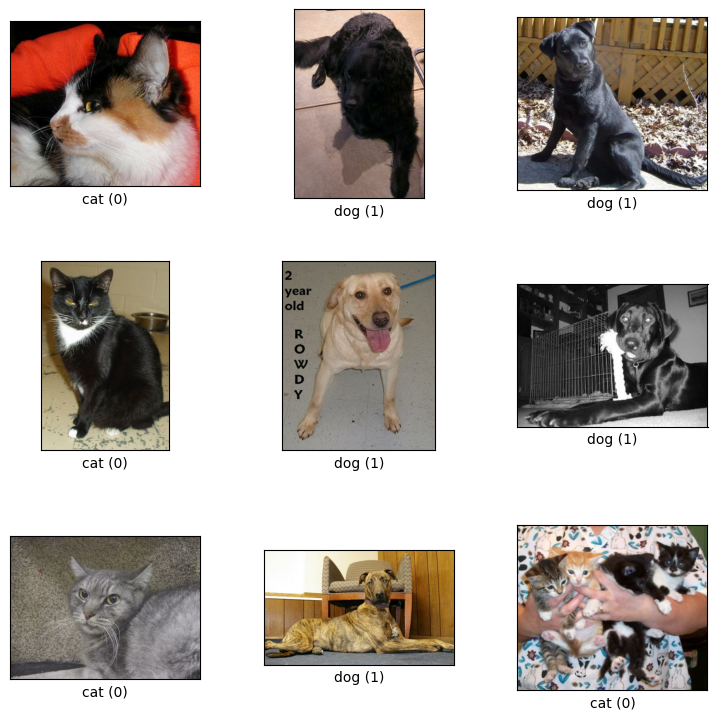

In [9]:
fig = tfds.show_examples(ds_train, ds_info)

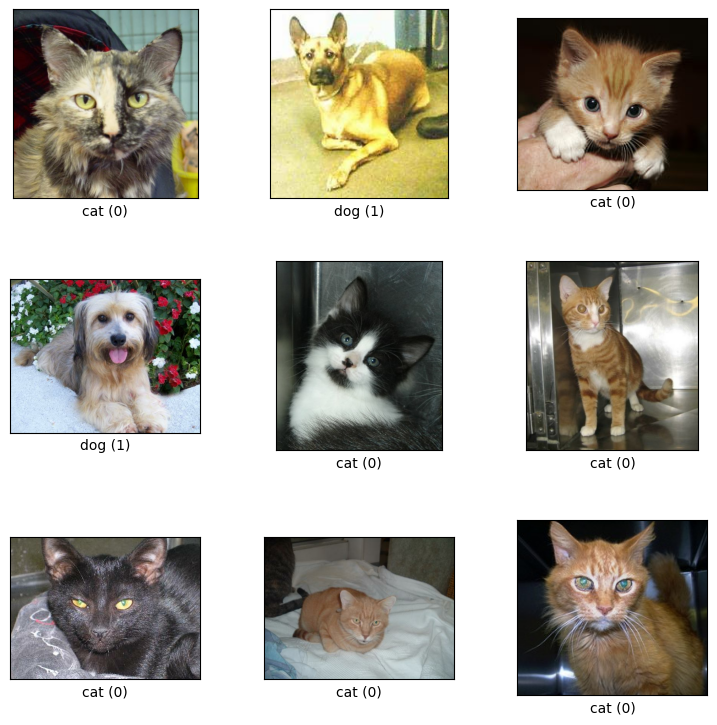

In [10]:
fig = tfds.show_examples(ds_test, ds_info)

**2) Input Normalization**

In [11]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [12]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    #ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### Ablation Study 실습 (2) 블록 구성하기

최근 나오는 일반적인 딥러닝 모델에서 이렇게 주요 구조를 모듈화 시켜 조금씩 바꾸어 쓸 수 있는 단위를 **블록(block)** 이라고 부른다. **레이어(layer)** 는 기본적으로 텐서플로우(TensorFlow), 케라스(Keras), 파이토치(PyTorch) 등에서 기본적으로 제공하는 단위이다. 우리는 여기서 한 단계 위인 "블록"을 단위로 모델을 만들 수 있어야 한다.

![image-2.png](attachment:image-2.png)

**ResNet**을 보면 ResNet-18, 34, 50, 101, 152로 다섯 가지 네트워크

각 네트워크를 하나씩 구현하는 방법도 있지만 매우 수고스럽고 변경사항이 생기면 모두 고쳐줘야 하는 불편함이 생기게 된다. 따라서 이후 실습에서 우리는 ResNet의 기본 구조인 블록을 먼저 구현하자.

**ResNet 기본 블록 만들기**

block_num은 레이어의 이름을 붙여주기 위해서 추가되었고 input_shape는 summary를 출력하기 위해서 넣어주었다.

In [13]:
# conv하나 -> BatchNormalization -> Activation을 하나의 블록으로 묶고
def conv_block(input_layer,
               channel,
               kernel_size,
               strides=1,
               activation='relu'):

    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',
                            strides=strides
                           )(input_layer)

    x = keras.layers.BatchNormalization()(x)

    if activation:
        x = keras.layers.Activation(activation)(x)

    return x

In [14]:
#위의 블록들을 ResNet-34의 경우는 2개를 묶어서 하나의 resnet블록으로 만들어주고,
# ResNet-50의 경우는 3개를 묶어서 하나의 resnet블록을 만들어준다.
def build_resnet_block(input_layer,
                       num_cnn=3,
                       channel=64,
                       block_num=0,
                       is_50=True):

    x = input_layer

    # ResNet-50
    if is_50:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None) # 마지막은 relu
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)

            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)

    # ResNet-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)

            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)


    return x

In [15]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10,
                 is_50=True,
                 activation='softmax',
                 name='ResNet_50'):

    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.

    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.

    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)

    # config list들의 길이만큼 반복해서 Residual block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x,
                               num_cnn=num_cnn,
                               channel=channel,
                               block_num=block_num,
                               is_50=is_50)
    if is_50==False:
        x = keras.layers.GlobalAveragePooling2D()(x)
        x = keras.layers.Dense(num_classes,
                           activation=activation,
                           kernel_initializer='he_normal'
                          )(x)

    model = keras.Model(inputs=input_layer, outputs=x, name=name)

    return model

### Ablation Study 실습 (3) ResNet Complete Model

이제 기본적인 블록을 만들 수 있는 함수를 만들었으니 이를 합쳐서 전체 모델을 만들 수 있는 함수를 만들어보자.

**1) ResNet-34**

먼저 작은 네트워크인 ResNet-34을 먼저 만들어 보자.

블록 내의 CNN 레이어 수와 채널 수는 블록마다 달라진다. 이는 ResNet-34과 ResNet-50에 따라서 같이 변화되므로 함수에 전달되어야 한다.

In [16]:
resnet_34 = build_resnet(input_shape=(224,224,3), is_50=False, activation='relu', name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 112, 112, 64)         0         ['batch_normalization[

**2) ResNet-50**

In [17]:
resnet_50 = build_resnet(input_shape=(224,224,3), is_50=True, activation='relu', name='ResNet_50')
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_36 (Conv2D)          (None, 112, 112, 64)         9472      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_36 (Ba  (None, 112, 112, 64)         256       ['conv2d_36[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_33 (Activation)  (None, 112, 112, 64)         0         ['batch_normalization_

**Ablation Study 실습 (4) 일반 네트워크(plain network) 만들기**

In [18]:
def build_plain_block(input_layer,
                      num_cnn=3,
                      channel=64,
                      block_num=0,
                      is_50=True):

    x = input_layer

    # plain-50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))

    # plain-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))

    return x

In [19]:
def build_plain(input_shape=(32,32,3),
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=10,
                   is_50=True,
                   activation='softmax',
                   name='Plain_50'):

    assert len(num_cnn_list) == len(channel_list)

    input_layer = keras.layers.Input(shape=input_shape)

    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)

    # config list들의 길이만큼 반복해서 plain block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plain_block(x,
                              num_cnn=num_cnn,
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)

    if is_50==False:
        x = keras.layers.GlobalAveragePooling2D()(x)
        x = keras.layers.Dense(num_classes,
                           activation=activation,
                           kernel_initializer='he_normal'
                          )(x)

    model = keras.Model(inputs=input_layer, outputs=x, name=name)

    return model

**1) Plain-34**

In [20]:
plain_34 = build_plain(input_shape=(224,224,3), is_50=False, activation='relu', name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_89 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_89 (Ba  (None, 112, 112, 64)      256       
 tchNormalization)                                               
                                                                 
 activation_82 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_90 (Conv2D)          (None, 56, 56, 64)        369

**1) Plain-50**

In [21]:
plain_50 = build_plain(input_shape=(224,224,3), is_50=True, activation='relu', name='Plain_50')
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_122 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_122 (B  (None, 112, 112, 64)      256       
 atchNormalization)                                              
                                                                 
 activation_115 (Activation  (None, 112, 112, 64)      0         
 )                                                               
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                          

### Ablation Study 실습 (4) ResNet vs PlainNet

이제 본격적으로 위에서 준비한 데이터셋과 모델의 성능 비교를 위해서 모델을 훈련하고 평가하자.

In [22]:
BATCH_SIZE = 16
EPOCH = 10

In [23]:
# 데이터 정의

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [24]:
# Plain-34 학습


plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 176s 131ms/step - loss: 2.3953 - accuracy: 0.5371 - val_loss: 2.2513 - val_accuracy: 0.4862
Epoch 2/10
1163/1163 [==============================] - 136s 117ms/step - loss: 2.2067 - accuracy: 0.5194 - val_loss: 2.2176 - val_accuracy: 0.5203
Epoch 3/10
1163/1163 [==============================] - 136s 117ms/step - loss: 2.2002 - accuracy: 0.5113 - val_loss: 2.2629 - val_accuracy: 0.5257
Epoch 4/10
1163/1163 [==============================] - 135s 116ms/step - loss: 2.1932 - accuracy: 0.5232 - val_loss: 2.2004 - val_accuracy: 0.5351
Epoch 5/10
1163/1163 [==============================] - 134s 115ms/step - loss: 2.1862 - accuracy: 0.5272 - val_loss: 2.1846 - val_accuracy: 0.5214
Epoch 6/10
1163/1163 [==============================] - 136s 117ms/step - loss: 2.1799 - accuracy: 0.5262 - val_loss: 2.1768 - val_accuracy: 0.5065
Epoch 7/10
1163/1163 [==============================] - 142s 122ms/step - loss: 2.1731 - accuracy: 0.5071 - val_

In [25]:
# ResNet-34 학습


resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 167s 128ms/step - loss: 4.1946 - accuracy: 0.4995 - val_loss: 3.9973 - val_accuracy: 0.4836
Epoch 2/10
1163/1163 [==============================] - 148s 127ms/step - loss: 3.9933 - accuracy: 0.5013 - val_loss: 3.9895 - val_accuracy: 0.4817
Epoch 3/10
1163/1163 [==============================] - 147s 127ms/step - loss: 3.9861 - accuracy: 0.5036 - val_loss: 3.9816 - val_accuracy: 0.4828
Epoch 4/10
1163/1163 [==============================] - 140s 121ms/step - loss: 3.9777 - accuracy: 0.5059 - val_loss: 3.9738 - val_accuracy: 0.4897
Epoch 5/10
1163/1163 [==============================] - 147s 127ms/step - loss: 3.9700 - accuracy: 0.5033 - val_loss: 3.9661 - val_accuracy: 0.4886
Epoch 6/10
1163/1163 [==============================] - 148s 127ms/step - loss: 3.9628 - accuracy: 0.5034 - val_loss: 3.9584 - val_accuracy: 0.4896
Epoch 7/10
1163/1163 [==============================] - 154s 133ms/step - loss: 3.9545 - accuracy: 0.5056 - val_

In [27]:
# Plain-50 학습

plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


InvalidArgumentError: ignored

In [ ]:
# ResNet-50 학습


resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


이제 Resnet과 Plain을 그래프를 그리고 비교해보자.

먼저 손실(loss)이 어떻게 다르게 진행되는지 비교해보자.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Training Loss 그래프
plt.plot(history_resnet_34.history['loss'], 'r', label='ResNet_34 Training Loss')
plt.plot(history_resnet_50.history['loss'], 'b', label='ResNet_50 Training Loss')
plt.plot(history_plain_34.history['loss'], 'y', label='Plain_34 Training Loss')
plt.plot(history_plain_50.history['loss'], 'g', label='Plain_50 Training Loss')

# Validation Loss 그래프
plt.plot(history_resnet_34.history['val_loss'], 'r', marker='o', label='ResNet_34 Validation Loss')
plt.plot(history_resnet_50.history['val_loss'], 'b', marker='o', label='ResNet_50 Validation Loss')
plt.plot(history_plain_34.history['val_loss'], 'y', marker='o', label='Plain_34 Validation Loss')
plt.plot(history_plain_50.history['val_loss'], 'g', marker='o', label='Plain_50 Validation Loss')

plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


그리고 정확도(accuracy)도 비교해 보자.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Training Accuracy 그래프
plt.plot(history_resnet_34.history['accuracy'], 'r', label='ResNet_34 Training Accuracy')
plt.plot(history_resnet_50.history['accuracy'], 'b', label='ResNet_50 Training Accuracy')
plt.plot(history_plain_34.history['accuracy'], 'y', label='Plain_34 Training Accuracy')
plt.plot(history_plain_50.history['accuracy'], 'g', label='Plain_50 Training Accuracy')

plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10, 6))

# Validation Accuracy 그래프
plt.plot(history_resnet_34.history['val_accuracy'], 'r', marker='o', label='ResNet_34 Validation Accuracy')
plt.plot(history_resnet_50.history['val_accuracy'], 'b', marker='o', label='ResNet_50 Validation Accuracy')
plt.plot(history_plain_34.history['val_accuracy'], 'y', marker='o', label='Plain_34 Validation Accuracy')
plt.plot(history_plain_50.history['val_accuracy'], 'g', marker='o', label='Plain_50 Validation Accuracy')

plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()


## 회고

이진 분류라 loss='binary_crossentropy'로 진행했는데 정확도가 너무 떨어져서,
loss='sparse_categorical_crossentropy'로 다시 진행했다.

왜 이렇게 해야 더 정확도가 올라가는지 궁금하다.